<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-26 14:28:02--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-08-26 14:28:03 (143 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



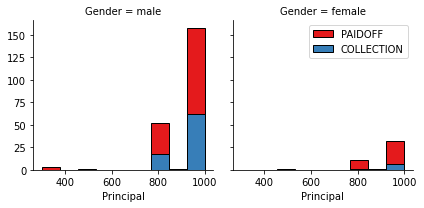

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

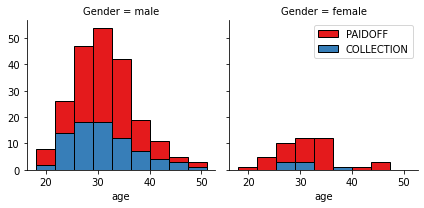

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


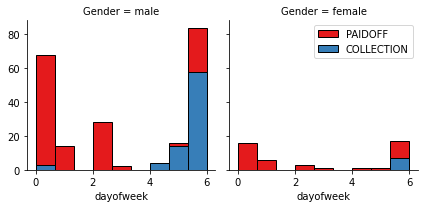

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


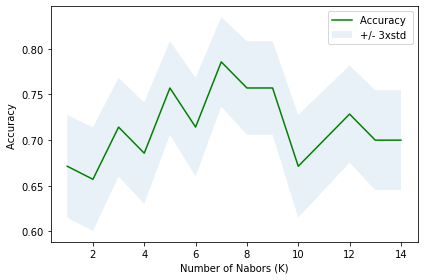

The best accuracy was with 0.7857142857142857 with k= 7


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k = 15

mean_acc = np.zeros((k-1))
std_acc = np.zeros((k-1))
ConfustionMx = [];
for n in range(1,k):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,k),mean_acc,'g')
plt.fill_between(range(1,k),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# shows the best accuracy from the plot
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

In [37]:
k = 7

neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_knn = neigh.predict(X_test)

In [38]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_knn))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# Decision Tree


In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [40]:
depth_range = range(1, 10)
jaccard_score_opti = []
f1_score_opti = []

for d in depth_range:
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = d)
    loanTree.fit(X_train, y_train)
    predTree = loanTree.predict(X_test)
    jaccard_score_opti.append(jaccard_score(y_test, predTree, average=None)[1])
    f1_score_opti.append(f1_score(y_test,predTree, average='weighted'))
    
result_tree_opti = pd.DataFrame([jaccard_score_opti, f1_score_opti], index = ['Jaccard', 'F1_score'], columns = ['d = 1', 'd = 2', 'd = 3', 'd = 4','d = 5', 'd = 6', 'd = 7', 'd = 8','d = 9'] )
result_tree_opti.columns.name = 'Evaluation matrices'
result_tree_opti

Evaluation matrices,d = 1,d = 2,d = 3,d = 4,d = 5,d = 6,d = 7,d = 8,d = 9
Jaccard,0.785714,0.785714,0.571429,0.571429,0.583333,0.768116,0.753623,0.753623,0.625000
F1_score,0.691429,0.691429,0.644599,0.644599,0.674185,0.706479,0.697881,0.697881,0.675824


In [41]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree.fit(X_train, y_train)

predTree = loanTree.predict(X_test)

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7714285714285715


In [44]:
import sys 
!{sys.executable} -m pip install pydotplus

In [45]:
import sys 
!{sys.executable} -m pip install graphviz

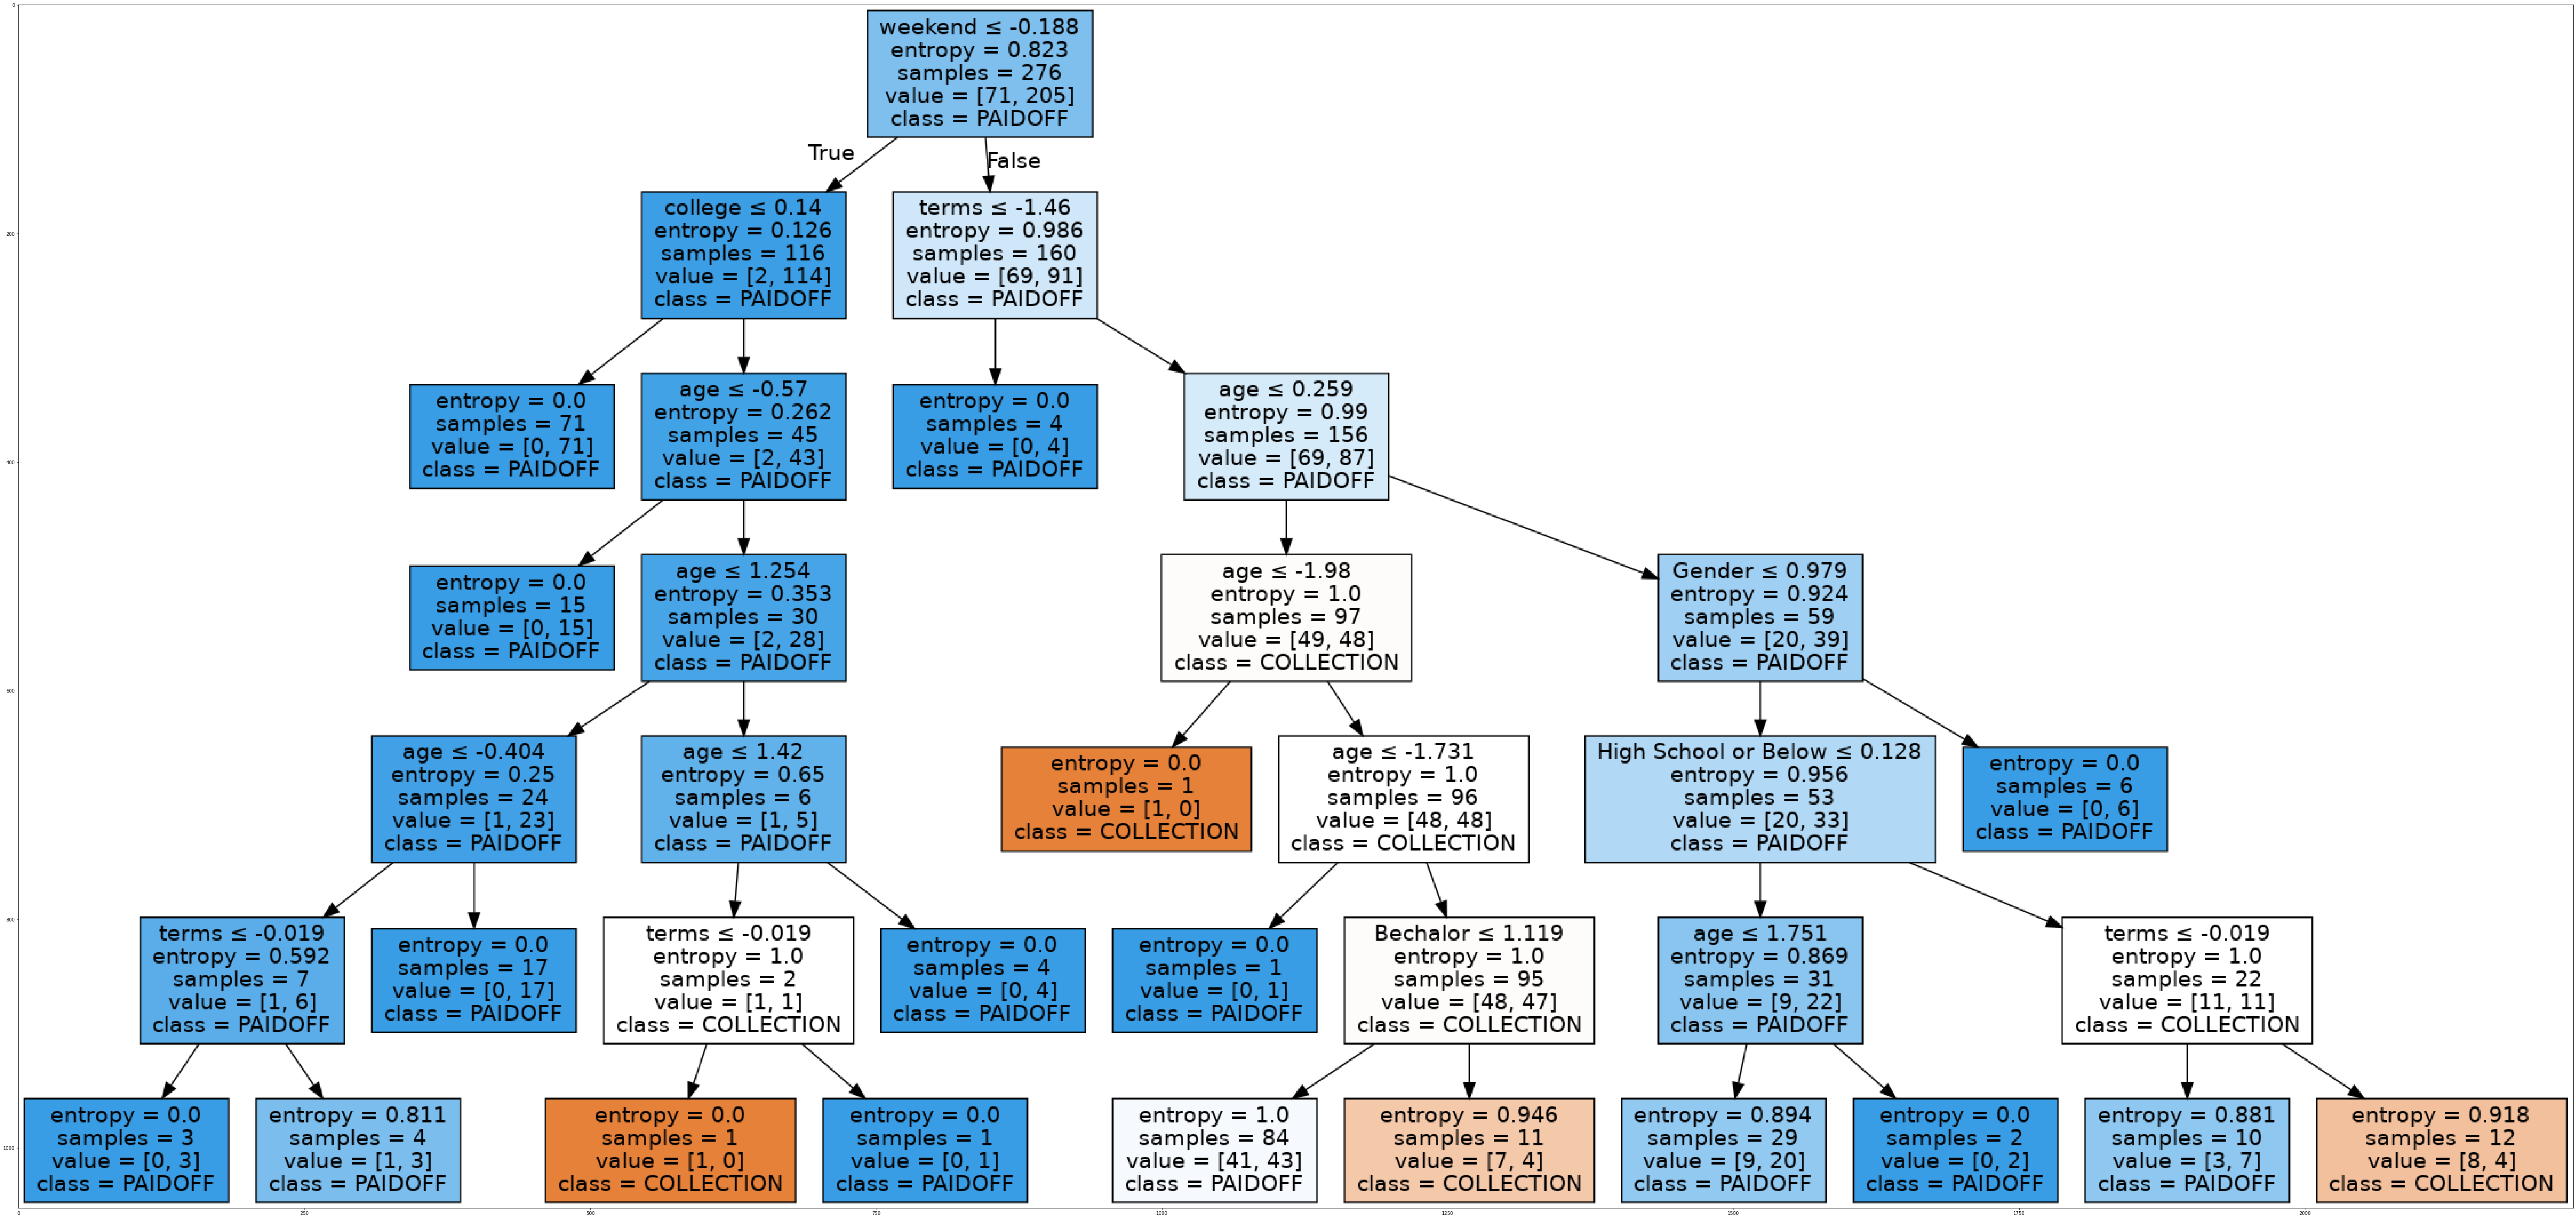

In [43]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

dot_data = StringIO()
filename = "drugtree.png"
featureNames = Feature.columns
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [47]:
from sklearn import svm

kernel_selection = ['linear', 'poly', 'rbf', 'sigmoid']
jaccard_score_opti2 = []
f1_score_opti2 = []

for k in kernel_selection:
    # train model
    clf = svm.SVC(kernel=k)
    clf.fit(X_train, y_train) 
    # predict the test set
    yhat_svm = clf.predict(X_test)
    jaccard_score_opti2.append(jaccard_score(y_test, yhat_svm, average=None)[1])
    f1_score_opti2.append(f1_score(y_test,yhat_svm, average='weighted'))

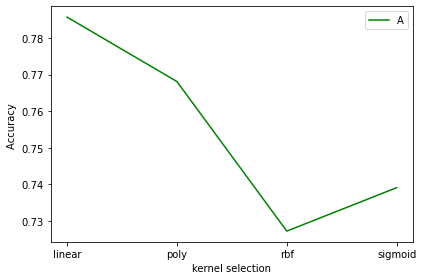

In [48]:
plt.plot(kernel_selection,jaccard_score_opti2,'g')
plt.legend('Accuracy jaccard score')
plt.ylabel('Accuracy ')
plt.xlabel('kernel selection')
plt.tight_layout()
plt.show()

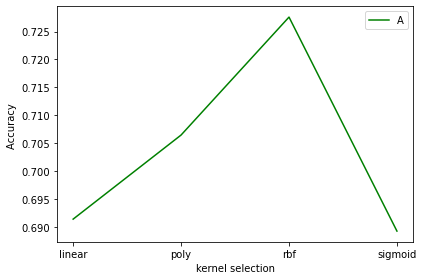

In [49]:
plt.plot(kernel_selection,f1_score_opti2,'g')
plt.legend('Accuracy f1 score')
plt.ylabel('Accuracy ')
plt.xlabel('kernel selection')
plt.tight_layout()
plt.show()

In [50]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

yhat_svm = clf.predict(X_test)

from sklearn.metrics import f1_score
print("f1_score: %.4f" % f1_score(y_test, yhat_svm, average='weighted'))
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_svm, average=None)

f1_score: 0.7276


array([0.18181818, 0.72727273])

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


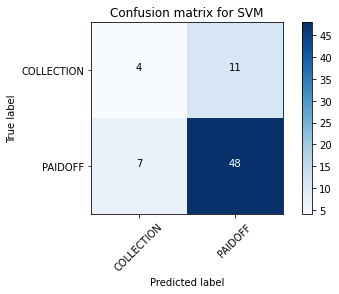

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_test, yhat_svm)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_svm))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix for SVM')

# Logistic Regression


Test 1: Accuracy at C = 0.1 when Solver = lbfgs is : 0.48275396048946634
Test 2: Accuracy at C = 0.1 when Solver = saga is : 0.4827491242869508
Test 3: Accuracy at C = 0.1 when Solver = liblinear is : 0.4981902487744225
Test 4: Accuracy at C = 0.1 when Solver = newton-cg is : 0.48275353245267283
Test 5: Accuracy at C = 0.1 when Solver = sag is : 0.48275474903866017


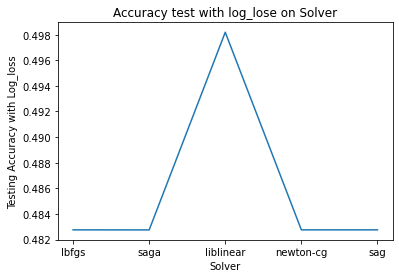



Test 6: Accuracy at C = 0.01 when Solver = lbfgs is : 0.4920179847937498
Test 7: Accuracy at C = 0.01 when Solver = saga is : 0.49201027821757454
Test 8: Accuracy at C = 0.01 when Solver = liblinear is : 0.5772287609479654
Test 9: Accuracy at C = 0.01 when Solver = newton-cg is : 0.492017801467927
Test 10: Accuracy at C = 0.01 when Solver = sag is : 0.49204232262653896


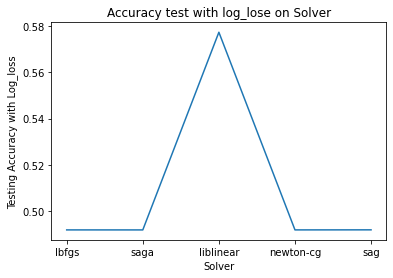



Test 11: Accuracy at C = 0.001 when Solver = lbfgs is : 0.5181766145124602
Test 12: Accuracy at C = 0.001 when Solver = saga is : 0.5181763781148587
Test 13: Accuracy at C = 0.001 when Solver = liblinear is : 0.670867975563743
Test 14: Accuracy at C = 0.001 when Solver = newton-cg is : 0.5181765961927621
Test 15: Accuracy at C = 0.001 when Solver = sag is : 0.5181864571248582


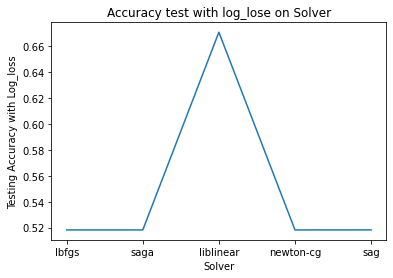



Test 16: Accuracy at C = 0.0001 when Solver = lbfgs is : 0.5238980680095987
Test 17: Accuracy at C = 0.0001 when Solver = saga is : 0.5239059466909759
Test 18: Accuracy at C = 0.0001 when Solver = liblinear is : 0.6906988027596805
Test 19: Accuracy at C = 0.0001 when Solver = newton-cg is : 0.5238982037362137
Test 20: Accuracy at C = 0.0001 when Solver = sag is : 0.5239008078460466


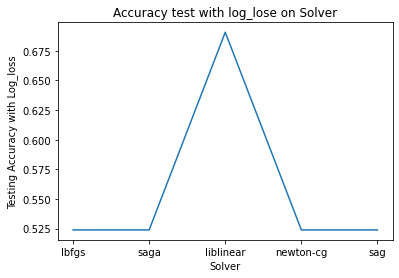

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
c_val = [0.1, 0.01, 0.001, 0.0001]
jaccard_score_opti3 = []
f1_score_opti3 = []
logloss_opti3 = []
iterations = 0
temp_score = []

for i, c in enumerate(c_val):
    for j, solver in enumerate(solvers):
        #train model
        LR = LogisticRegression(C=c, solver=solver).fit(X_train,y_train)
        # predict test set
        yhat_LR = LR.predict(X_test)
        yhat_LR_prob = LR.predict_proba(X_test)
        iterations += 1
        print('Test {}: Accuracy at C = {} when Solver = {} is : {}'
             .format(iterations, c, solver, log_loss(y_test, yhat_LR_prob)))
        logloss_opti3.append(log_loss(y_test, yhat_LR_prob))
        jaccard_score_opti3.append(jaccard_score(y_test, yhat_svm, average=None)[1])
        f1_score_opti3.append(f1_score(y_test,yhat_svm, average='weighted'))    
    if iterations <= 5:
        plt.plot(solvers, logloss_opti3)
        plt.xlabel('Solver')
        plt.ylabel('Testing Accuracy with Log_loss')
        plt.title('Accuracy test with log_lose on Solver')
        plt.show()
    if iterations <= 10 and iterations > 5:
        plt.plot(solvers, logloss_opti3[5:10])
        plt.xlabel('Solver')
        plt.ylabel('Testing Accuracy with Log_loss')
        plt.title('Accuracy test with log_lose on Solver')
        plt.show()
    if iterations <= 15 and iterations > 10:
        plt.plot(solvers, logloss_opti3[10:16])
        plt.xlabel('Solver')
        plt.ylabel('Testing Accuracy with Log_loss')
        plt.title('Accuracy test with log_lose on Solver')
        plt.show()
    if iterations <= 20 and iterations > 15:
        plt.plot(solvers, logloss_opti3[15:21])
        plt.xlabel('Solver')
        plt.ylabel('Testing Accuracy with Log_loss')
        plt.title('Accuracy test with log_lose on Solver')
        plt.show()
        
    print('\n')

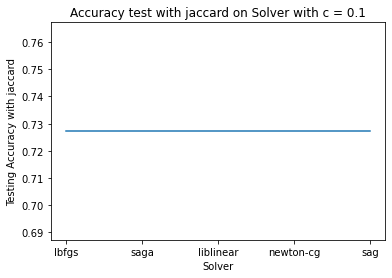

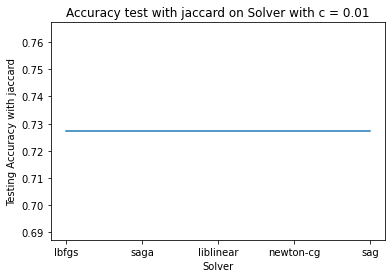

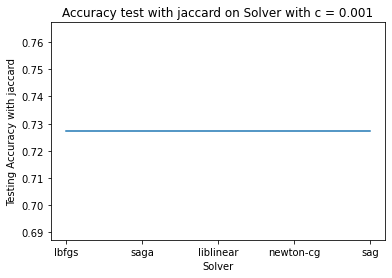

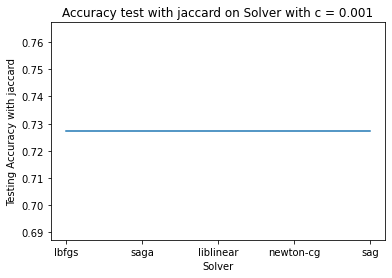

In [53]:
plt.plot(solvers, jaccard_score_opti3[0:5])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with jaccard')
plt.title('Accuracy test with jaccard on Solver with c = 0.1')
plt.show()

plt.plot(solvers, jaccard_score_opti3[5:10])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with jaccard')
plt.title('Accuracy test with jaccard on Solver with c = 0.01')
plt.show()

plt.plot(solvers, jaccard_score_opti3[11:16])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with jaccard')
plt.title('Accuracy test with jaccard on Solver with c = 0.001')
plt.show()

plt.plot(solvers, jaccard_score_opti3[15:21])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with jaccard')
plt.title('Accuracy test with jaccard on Solver with c = 0.001')
plt.show()

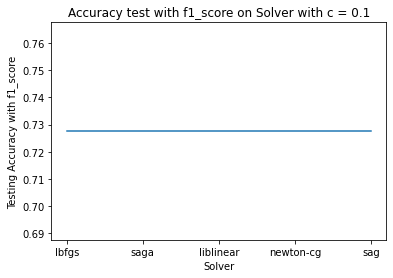

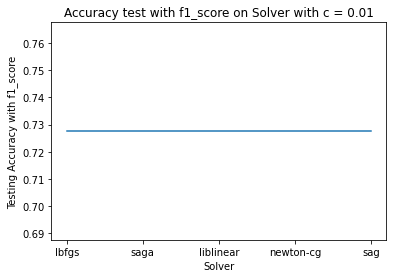

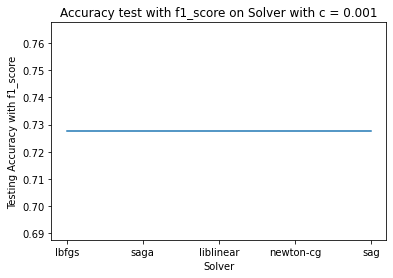

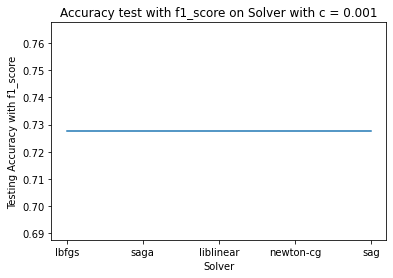

In [54]:
plt.plot(solvers, f1_score_opti3[0:5])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with f1_score')
plt.title('Accuracy test with f1_score on Solver with c = 0.1')
plt.show()

plt.plot(solvers, f1_score_opti3[5:10])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with f1_score')
plt.title('Accuracy test with f1_score on Solver with c = 0.01')
plt.show()

plt.plot(solvers, f1_score_opti3[11:16])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with f1_score')
plt.title('Accuracy test with f1_score on Solver with c = 0.001')
plt.show()

plt.plot(solvers, f1_score_opti3[15:21])
plt.xlabel('Solver')
plt.ylabel('Testing Accuracy with f1_score')
plt.title('Accuracy test with f1_score on Solver with c = 0.001')
plt.show()

In [55]:
LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
# predict test set
yhat_LR = LR.predict(X_test)
yhat_LR_prob = LR.predict_proba(X_test)

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_LR, average=None)

array([0.1 , 0.74])

Confusion matrix, without normalization
[[ 2 13]
 [ 5 50]]


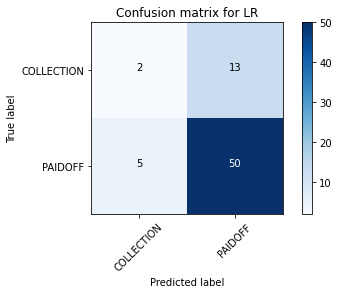

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix1 = confusion_matrix(y_test, yhat_LR)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix for LR')

# Model Evaluation using Test set


In [30]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [31]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-26 14:44:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-26 14:44:26 (55.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [32]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [57]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
Feature2.head()

X2 = Feature2
y2 = test_df['loan_status'].values

X2 = preprocessing.StandardScaler().fit(X).transform(X)

In [58]:
X2 = Feature2
X2[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [59]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=4)

k = 9

neigh2 = KNeighborsClassifier(n_neighbors = k).fit(X2_train,y2_train)

yhat_knn2 = neigh2.predict(X2_test)

loanTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree2.fit(X2_train, y2_train)

predTree2 = loanTree.predict(X2_test)

clf2 = svm.SVC(kernel='rbf')
clf2.fit(X2_train, y2_train) 

yhat_svm2 = clf.predict(X2_test)

LR2 = LogisticRegression(C=0.1, solver='liblinear').fit(X2_train,y2_train)

yhat_LR2 = LR2.predict(X2_test)
yhat_LR_prob2 = LR2.predict_proba(X2_test)

In [60]:
jacc_knn = jaccard_score(y2_test, yhat_knn2, average=None)
f1_score_knn = f1_score(y2_test, yhat_knn2, average='weighted')

jacc_tree = jaccard_score(y2_test, predTree2, average=None)
f1_score_tree = f1_score(y2_test, predTree2, average='weighted')

jacc_svm = jaccard_score(y2_test, yhat_svm2, average=None)
f1_score_svm = f1_score(y2_test, yhat_svm2, average='weighted')

jacc_LR = jaccard_score(y2_test, yhat_LR2, average=None)
f1_score_LR = f1_score(y2_test, yhat_LR2, average='weighted')
log_loss_LR2 = log_loss(y2_test, yhat_LR_prob2)

In [61]:
reportInput = [
            {'Algorithm':'KNN', 'Jaccard':jacc_knn[1], 'F1-score': f1_score_knn, 'Logloss': None},
            {'Algorithm':'Decision Tree', 'Jaccard':jacc_tree[1], 'F1-score': f1_score_tree, 'Logloss': None},
            {'Algorithm':'SVM', 'Jaccard':jacc_svm[1], 'F1-score': f1_score_svm, 'Logloss': None},
            {'Algorithm':'LogisticRegression', 'Jaccard':jacc_LR[1], 'F1-score': f1_score_LR, 'Logloss': log_loss_LR2}
         ] 
reportModel = pd.DataFrame(reportInput)
reportModel

,Algorithm,Jaccard,F1-score,Logloss
0,KNN,0.909091,0.865801,NaN
1,Decision Tree,0.900000,0.921850,NaN
2,SVM,0.909091,0.865801,NaN
3,LogisticRegression,0.909091,0.865801,0.437674


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
